In [505]:
%matplotlib notebook
import cvxpy as cp
import dccp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import zero_one_loss, confusion_matrix
from scipy.io import arff
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
import matplotlib.patches as mpatches
import json

torch.set_default_dtype(torch.float64)
XDIM = 2
COST = 0.5
SLOPE_C = 1
X_LOWER_BOUND = -10
X_UPPER_BOUND = 10
V_LOWER_BOUND = 0.1
V_UPPER_BOUND = 2

# Datasets

In [506]:
def gen_data_case1():
    posX = torch.arange(-0.5, 2, 0.02)
    posX = torch.transpose(torch.stack((posX, torch.zeros(len(posX)))), 0, 1)
    negX = torch.arange(0.5, 3, 0.02)
    negX = torch.transpose(torch.stack((torch.zeros(len(negX)), negX)), 0, 1)

    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y

def gen_data_case2(N, pos_ranges, neg_ranges):
    """
    pos_ranges: a tuple of tensors of length XDIM.
    (scales tensor, offsets tensor)
    """
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.rand((pos_samples_num, XDIM))*pos_ranges[0] + pos_ranges[1]
    negX = torch.rand((neg_samples_num, XDIM))*neg_ranges[0] + neg_ranges[1]
    
#     temp = torch.rand((neg_samples_num//50, XDIM))*torch.Tensor([0.5, 0.5]) + torch.Tensor([0.1, -0.25]) # remove this
#     negX = torch.cat((negX, temp), 0)
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y


def load_spam_dataset():
    path = r"C:\Users\sagil\Desktop\nir project\tip_spam_data\IS_journal_tip_spam.arff"
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    most_disc = ['qTips_plc', 'rating_plc', 'qEmail_tip', 'qContacts_tip', 'qURL_tip', 'qPhone_tip', 'qNumeriChar_tip', 'sentistrength_tip', 'combined_tip', 'qWords_tip', 'followers_followees_gph', 'qunigram_avg_tip', 'qTips_usr', 'indeg_gph', 'qCapitalChar_tip', 'class1']
    df = df[most_disc]
    df["class1"].replace({b'spam': -1, b'notspam': 1}, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True)

    Y = df['class1'].values
    X = df.drop('class1', axis = 1).values
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    return torch.from_numpy(X), torch.from_numpy(Y)

def gen_data(N, informative_frac=1, shift_range=1, scale_range=1, noise_frac=0.01, seed=None):
    
    np.random.seed(seed)
    n_informative = int(informative_frac*XDIM)
    n_redundant = XDIM - n_informative
    shift_arr = shift_range*np.random.randn(XDIM)
    scale_arr = scale_range*np.random.randn(XDIM)
    X, Y = make_classification(n_samples=N, n_features=XDIM, n_informative=n_informative, n_redundant=n_redundant,
                               flip_y=noise_frac, shift=shift_arr, scale=scale_arr, random_state=seed)
    Y[Y == 0] = -1
    return torch.from_numpy(X), torch.from_numpy(Y)

# Utils

In [507]:
def split_data(X, Y, percentage):
    num_val = int(len(X)*percentage)
    return X[num_val:], Y[num_val:], X[:num_val], Y[:num_val]

def shuffle(X, Y):
    data = torch.cat((X, Y), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, :2]
    Y = data[:, 2]
    return X, Y

def conf_mat(Y1, Y2):
    num_of_samples = len(Y1)
    mat = confusion_matrix(Y1, Y2, labels=[-1, 1])*100/num_of_samples
    acc = np.trace(mat)
    return mat, acc

def pred(X, w, b):
    return torch.sign(score(X, w, b))

def calc_accuracy(Y, Ypred):
    num = len(Y)
    temp = Y - Ypred
    acc = len(temp[temp == 0])*1./num
    return acc

def evaluate_model(X, Y, w, b, v, ccp, strategic):
    if not strategic:
        Xopt = X
    else:
        Xopt = ccp.optimize_X(X, w, b, v)
    Ypred = pred(Xopt, w, b)
    return calc_accuracy(Y, Ypred)

# Visualization

In [508]:
def visualize_weights(w1, b1, w2, b2):
    fig = plt.figure()
    plt.bar(np.arange(XDIM + 1), np.append(w1, b1), color='b', alpha=0.5)
    plt.bar(np.arange(XDIM + 1), np.append(w2, b2), color='r', alpha=0.5)
    plt.show()
    
def visualize_data3D(X, Y):
    if not XDIM == 3:
        return
    
    Xpos = X[Y == 1]
    Xneg = X[Y == -1]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='purple')
    plt.show()
    
def visualize_data2D(X, Y):
    if not XDIM == 2:
        return
    
    Xpos = X[Y == 1]
    Xneg = X[Y == -1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='purple')
    
#     ax.set_title('Fixed VS flexible cost experiment dataset')
#     plt.savefig('plots/fixed_cost_VS_flexible_cost_dataset_final.pdf', format='pdf')
#     plt.savefig('plots/fixed_cost_VS_flexible_cost_dataset_final.eps', format='eps')
#     plt.savefig('plots/fixed_cost_VS_flexible_cost_dataset_final.png', format='png')
    
    plt.show()
    
def visualize_data(X, Y):
    if XDIM == 2:
        visualize_data2D(X, Y)
    else:
        visualize_data3D(X, Y)
    
def visualize_strategic_data3D(Xval, Xval_opt_fixed, Xval_opt_flexible, Yval,w_non_strategic, b_non_strategic, w_fixed, b_fixed, w_flexible, b_flexible):
    if not XDIM == 3:
        return

    Xpos = Xval[Yval == 1]
    Xneg = Xval[Yval == -1]
    XposOptFixed = Xval_opt_fixed[Yval == 1]
    XnegOptFixed = Xval_opt_fixed[Yval == -1]
    XposOptFlex = Xval_opt_flexible[Yval == 1]
    XnegOptFlex = Xval_opt_flexible[Yval == -1]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='blue')

    ax.scatter(XposOptFixed[:, 0], XposOptFixed[:, 1], XposOptFixed[:, 2], marker='+', color='red')
    ax.scatter(XnegOptFixed[:, 0], XnegOptFixed[:, 1], XnegOptFixed[:, 2], marker='_', color='red')

    ax.scatter(XposOptFlex[:, 0], XposOptFlex[:, 1], XposOptFlex[:, 2], marker='+', color='green')
    ax.scatter(XnegOptFlex[:, 0], XnegOptFlex[:, 1], XnegOptFlex[:, 2], marker='_', color='green')

    range_arr = torch.arange(-2, 2 + 1)
    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_non_strategic[0] * xx - w_non_strategic[1] * yy - b_non_strategic) * 1. /w_non_strategic[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='blue')

    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_fixed[0] * xx - w_fixed[1] * yy - b_fixed) * 1. /w_fixed[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='red')
    
    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_flexible[0] * xx - w_flexible[1] * yy - w_flexible) * 1. /w_flexible[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='red')
    
#     ax.set_xlim3d(-1.2, 1.2)
#     ax.set_ylim3d(-1.2, 1.2)
#     ax.set_zlim3d(-1.2, 1.2)
#     ax.view_init(25, 45)
#     plt.savefig('plots/simple_strategic_classification.pdf', format='pdf')
#     plt.savefig('plots/simple_strategic_classification.eps', format='eps')
#     plt.savefig('plots/simple_strategic_classification.png', format='png')

#     plt.xlim(-2, 2)
#     plt.ylim(-2, 2)
#     ax.set_zlim(-2,2)
    plt.show()

def visualize_strategic_data2D(Xval, Xval_opt_fixed, Xval_opt_flexible, Yval,w_non_strategic, b_non_strategic, w_fixed, b_fixed, w_flexible, b_flexible):
    if not XDIM == 2:
        return

    Xpos = Xval[Yval == 1]
    Xneg = Xval[Yval == -1]
    XposOptFixed = Xval_opt_fixed[Yval == 1]
    XnegOptFixed = Xval_opt_fixed[Yval == -1]
    XposOptFlex = Xval_opt_flexible[Yval == 1]
    XnegOptFlex = Xval_opt_flexible[Yval == -1]

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='blue')

    ax.scatter(XposOptFixed[:, 0], XposOptFixed[:, 1], marker='+', color='red')
    ax.scatter(XnegOptFixed[:, 0], XnegOptFixed[:, 1], marker='_', color='red')
    
    ax.scatter(XposOptFlex[:, 0], XposOptFlex[:, 1], marker='+', color='green')
    ax.scatter(XnegOptFlex[:, 0], XnegOptFlex[:, 1], marker='_', color='green')

    range_arr = torch.arange(-2, 2 + 1)
    xx = torch.meshgrid(range_arr)[0]
    z = (-w_non_strategic[0] * xx - b_non_strategic) * 1. /w_non_strategic[1]
    ax.plot(xx.numpy(), z.numpy(), alpha=0.2, color='blue')

    xx = torch.meshgrid(range_arr)[0]
    z = (-w_fixed[0] * xx - b_fixed) * 1. /w_fixed[1]
    ax.plot(xx.numpy(), z.numpy(), alpha=0.2, color='red')
    
    xx = torch.meshgrid(range_arr)[0]
    z = (-w_flexible[0] * xx - b_flexible) * 1. /w_flexible[1]
    ax.plot(xx.numpy(), z.numpy(), alpha=0.2, color='green')
    
#     plt.xlim(-7, 3)
#     plt.ylim(-4, 4)
#     plt.savefig('plots/fixed_cost_VS_flexible_cost_final.pdf', format='pdf')
#     plt.savefig('plots/fixed_cost_VS_flexible_cost_final.eps', format='eps')
#     plt.savefig('plots/fixed_cost_VS_flexible_cost_final.png', format='png')

    plt.show()
    
def visualize_strategic_data(Xval, Xval_opt_fixed, Xval_opt_flexible, Yval,w_non_strategic, b_non_strategic, w_fixed, b_fixed, w_flexible, b_flexible):
    if XDIM == 2:
        visualize_strategic_data2D(Xval, Xval_opt_fixed, Xval_opt_flexible, Yval,w_non_strategic, b_non_strategic, w_fixed, b_fixed, w_flexible, b_flexible)
    else:
        visualize_strategic_data3D(Xval, Xval_opt_fixed, Xval_opt_flexible, Yval,w_non_strategic, b_non_strategic, w_fixed, b_fixed, w_flexible, b_flexible)
        
def visualize_training_errors(train_errors, val_errors):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_errors)), np.mean(train_errors, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_errors)), val_errors, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])

    plt.show()
    
def visualize_training_losses(train_losses, val_losses):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_losses)), np.mean(train_losses, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_losses)), val_losses, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])
    
    plt.show()

# CCP classes

In [509]:
class CCP:
    def __init__(self, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(XDIM)
        self.xt = cp.Parameter(XDIM)
        self.r = cp.Parameter(XDIM)
        self.w = cp.Parameter(XDIM)
        self.b = cp.Parameter(1)
        self.v = cp.Parameter(XDIM, nonneg=True) # vvv

        target = self.x@self.f_derivative(self.xt, self.w, self.b) - self.g(self.x, self.w, self.b) - self.c(self.x, self.r, self.v) # vvv
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
        print("problem is DCP:", self.prob.is_dcp())
        print("problem is DPP:", self.prob.is_dpp())
        
    def ccp(self, r):
        """
        numpy to numpy
        """
        
        self.xt.value = r
        self.r.value = r
        diff = np.linalg.norm(self.xt.value - self.x.value)
        while diff > 0.0001:
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, v):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        v = v.detach().numpy() # vvv
        X = X.numpy()
        
        self.w.value = w
        self.b.value = b
        self.v.value = v # vvv
        
        return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])

In [510]:
class DELTA():
    
    def __init__(self, funcs):
        self.g = funcs["g"]
        self.c = funcs["c_dpp_form"]
        
        self.x = cp.Variable(XDIM)
#         self.r = cp.Parameter(XDIM, value = np.random.randn(XDIM))
        self.w = cp.Parameter(XDIM, value = np.random.randn(XDIM))
        self.b = cp.Parameter(1, value = np.random.randn(1))
#         self.v = cp.Parameter(XDIM, value = np.random.rand(XDIM), nonneg=True) # vvv
        self.rv = cp.Parameter(XDIM, value = np.random.randn(XDIM)) # r times v
        self.r2v = cp.Parameter(XDIM, value = np.random.randn(XDIM)) # r squared times v
        self.f_der = cp.Parameter(XDIM, value = np.random.randn(XDIM))

        target = self.x@self.f_der - self.g(self.x, self.w, self.b) - self.c(self.x, self.rv, self.r2v)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.f_der, self.w, self.b, self.rv, self.r2v], variables=[self.x]) # vvv
        
    def optimize_X(self, X, F_DER, w, b, v):
        rv = X*v
        r2v = (X**2)*v
        return self.layer(F_DER, w, b, rv, r2v)[0]
    

# Gain & Cost functions

In [515]:
def score(x, w, b):
    return x@w + b

def f(x, w, b):
    return 0.5*cp.norm(cp.hstack([1, (SLOPE_C*score(x, w, b) + 1)]), 2)

def g(x, w, b):
    return 0.5*cp.norm(cp.hstack([1, (SLOPE_C*score(x, w, b) - 1)]), 2)

def c(x, r, v): # vvv
    return COST*cp.abs(cp.multiply(x, r) - cp.square(r))@v     # COST*(cp.pos(cp.square(x)-cp.multiply(x, r)))@v    # COST*cp.square(x-r)@v

def c_dpp_form(x, rv, r2v):
    return COST*cp.sum(cp.abs(cp.multiply(x, rv) - r2v))                       # COST*cp.sum(cp.pos(cp.multiply(cp.square(x), v) - cp.multiply(rv, x)))     # COST*cp.sum(cp.multiply(cp.square(x), v) - 2*cp.multiply(x, rv) + r2v)

def f_derivative(x, w, b):
    return 0.5*SLOPE_C*((SLOPE_C*score(x, w, b) + 1)/cp.sqrt((SLOPE_C*score(x, w, b) + 1)**2 + 1))*w

def g_derivative(x, w, b):
    return 0.5*SLOPE_C*((SLOPE_C*score(x, w, b) - 1)/cp.sqrt((SLOPE_C*score(x, w, b) - 1)**2 + 1))*w

funcs = {"f": f, "g": g, "f_derivative": f_derivative, "g_derivative": g_derivative,
         "c": c, "c_dpp_form": c_dpp_form, "score": score}

# Data generation

<IPython.core.display.Javascript object>


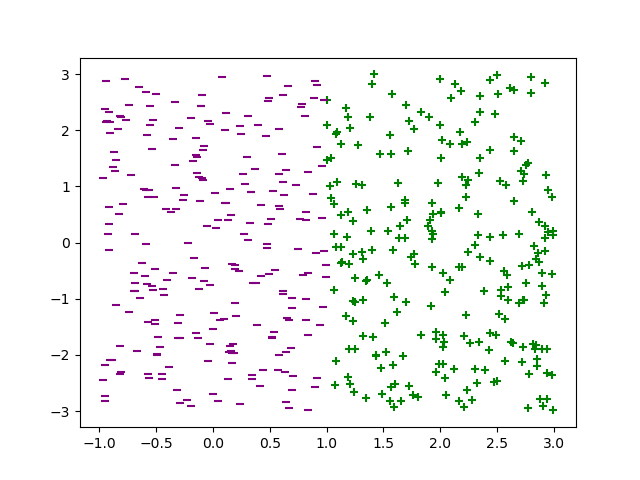

percent of positive samples: 50.0%


In [526]:
N = 500
# X, Y = gen_data(N, informative_frac=1, seed=111)
# X, Y = load_spam_dataset()
X, Y = gen_data_case2(N, (torch.Tensor([2, 6]), torch.Tensor([1, -3])), (torch.Tensor([2, 6]), torch.Tensor([-1, -3])))

assert(len(X[0]) == XDIM)
# X, Y, Xval, Yval = split_data(X, Y, 0.25)
Xval, Yval = X, Y
visualize_data(X, Y)
print("percent of positive samples: {}%".format(100 * len(Y[Y == 1]) / len(Y)))

# Train

In [527]:
def fit(evaluate, loss, params, X, Y, Xval, Yval, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None, calc_train_errors=False):
    
    train_dset = TensorDataset(X, Y)
    train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
    opt = opt(params, **opt_kwargs)

    train_losses = []
    val_losses = []
    train_errors = []
    val_errors = []
    
    total_time = time.time()
    for epoch in range(epochs):
        t1 = time.time()
        
        batch = 1
        train_losses.append([])
        train_errors.append([])
        for Xbatch, Ybatch in train_loader:
            opt.zero_grad()
            l = loss(Xbatch, Ybatch)
            l.backward()
            opt.step()
            train_losses[-1].append(l.item())
            if calc_train_errors:
                with torch.no_grad():
                    e = evaluate(Xbatch, Ybatch)
                    train_errors[-1].append(1-e)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | err: %3.5f" % 
                          (batch, len(train_loader), np.mean(train_losses[-1]), np.mean(train_errors[-1])))
            else:
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1])))
            batch += 1
            if callback is not None:
                callback()
                
#         with torch.no_grad():
#             val_losses.append(loss(Xval, Yval).item())
#             val_errors.append(1-evaluate(Xval, Yval))
            
        t2 = time.time()
#         if verbose:
#             print("----- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))
    print("training time: {} seconds".format(time.time()-total_time)) 
    return train_errors, val_errors, train_losses, val_losses


def get_f_ders(XT, w, b):
    """
    tensor to tensor
    """
    return torch.stack([0.5*SLOPE_C*((SLOPE_C*score(xt, w, b) + 1)/torch.sqrt((SLOPE_C*score(xt, w, b) + 1)**2 + 1))*w for xt in XT])


In [553]:
ccp = CCP(funcs)
delta = DELTA(funcs)
v_true = torch.ones(XDIM, requires_grad=False) # torch.rand(XDIM, requires_grad=False) + 0.5

def loss(X, Y, w, b, v, lam, strategic=True): # vvv
    if strategic:
        v = torch.abs(v)
        XT = ccp.optimize_X(X, w, b, v) # vvv
        F_DER = get_f_ders(XT, w, b)
        Xopt = delta.optimize_X(X, F_DER, w, b, v) 
        output = score(Xopt, w, b)
        loss = torch.mean(torch.clamp(1 - output * Y, min=0)) + lam*torch.abs(torch.sum(v_true)-torch.sum(v)) # lam*torch.norm(v_true-v)
    else:
        output = score(X, w, b)
        loss = torch.mean(torch.clamp(1 - output * Y, min=0))
        
    return loss

problem is DCP: True
problem is DPP: False


In [543]:
EPOCHS = 10
BATCH_SIZE = 32
LAMBDA = 0.1

# non-strategic classification
print("---------- training non-strategically----------")
w_non_strategic = torch.zeros(XDIM, requires_grad=True)
b_non_strategic = torch.zeros(1, requires_grad=True)
v_non_strategic = torch.zeros(XDIM, requires_grad=True)

fit_res_non_strategic = fit(lambda X, Y: evaluate_model(X, Y, w_non_strategic, b_non_strategic, v_non_strategic, ccp, strategic=False), 
                               lambda X, Y: loss(X, Y, w_non_strategic, b_non_strategic, v_non_strategic, 0, strategic=False), [w_non_strategic, b_non_strategic], X, Y, Xval, Yval,
                               opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                               batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False)

w_non_strategic.requires_grad = False
b_non_strategic.requires_grad = False

# strategic classification with flexible v
print("---------- training strategically with flexible v----------")
w_flexible = torch.zeros(XDIM, requires_grad=True)
b_flexible = torch.zeros(1, requires_grad=True)
v_flexible = torch.ones(XDIM, requires_grad=True)

fit_res_flexible = fit(lambda X, Y: evaluate_model(X, Y, w_flexible, b_flexible, v_flexible, ccp, strategic=True), 
                               lambda X, Y: loss(X, Y, w_flexible, b_flexible, v_flexible, LAMBDA, strategic=True), [w_flexible, b_flexible, v_flexible], X, Y, Xval, Yval,
                               opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                               batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False)

w_flexible.requires_grad = False
b_flexible.requires_grad = False
v_flexible.requires_grad = False
print("v flexible: ", v_flexible)

# strategic classification with fixed v
print("---------- training strategically with fixed v----------")
w_fixed = torch.zeros(XDIM, requires_grad=True)
b_fixed = torch.zeros(1, requires_grad=True)
v_fixed = v_true

fit_res_fixed = fit(lambda X, Y: evaluate_model(X, Y, w_fixed, b_fixed, v_fixed, ccp, strategic=True), 
                               lambda X, Y: loss(X, Y, w_fixed, b_fixed, v_fixed, 0, strategic=True), [w_fixed, b_fixed], X, Y, Xval, Yval,
                               opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                               batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False)

w_fixed.requires_grad = False
b_fixed.requires_grad = False


---------- training non-strategically----------
batch 001 / 016 | loss: 1.00000
batch 002 / 016 | loss: 0.94895
batch 003 / 016 | loss: 0.85256
batch 004 / 016 | loss: 0.87063
batch 005 / 016 | loss: 0.82445
batch 006 / 016 | loss: 0.80627
batch 007 / 016 | loss: 0.75709
batch 008 / 016 | loss: 0.71696
batch 009 / 016 | loss: 0.68691
batch 010 / 016 | loss: 0.65817
batch 011 / 016 | loss: 0.62467
batch 012 / 016 | loss: 0.60208
batch 013 / 016 | loss: 0.57995
batch 014 / 016 | loss: 0.56526
batch 015 / 016 | loss: 0.55345
batch 016 / 016 | loss: 0.52874
batch 001 / 016 | loss: 0.18765
batch 002 / 016 | loss: 0.23641
batch 003 / 016 | loss: 0.28057
batch 004 / 016 | loss: 0.25837
batch 005 / 016 | loss: 0.24665
batch 006 / 016 | loss: 0.23730
batch 007 / 016 | loss: 0.22623
batch 008 / 016 | loss: 0.21650
batch 009 / 016 | loss: 0.21069
batch 010 / 016 | loss: 0.19856
batch 011 / 016 | loss: 0.19738
batch 012 / 016 | loss: 0.19096
batch 013 / 016 | loss: 0.19405
batch 014 / 016 | loss: 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:163: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


tensor(2., grad_fn=<SumBackward0>)
batch 001 / 016 | loss: 1.00000
tensor(2., grad_fn=<SumBackward0>)
batch 002 / 016 | loss: 0.96229
tensor(1.9698, grad_fn=<SumBackward0>)
batch 003 / 016 | loss: 0.94204
tensor(2.0538, grad_fn=<SumBackward0>)
batch 004 / 016 | loss: 0.95311
tensor(2.0913, grad_fn=<SumBackward0>)
batch 005 / 016 | loss: 0.96295
tensor(2.1031, grad_fn=<SumBackward0>)
batch 006 / 016 | loss: 0.96888
tensor(2.0984, grad_fn=<SumBackward0>)
batch 007 / 016 | loss: 0.96389
tensor(2.0906, grad_fn=<SumBackward0>)
batch 008 / 016 | loss: 0.95128
tensor(2.0692, grad_fn=<SumBackward0>)
batch 009 / 016 | loss: 0.98977
tensor(2.0684, grad_fn=<SumBackward0>)
batch 010 / 016 | loss: 0.99209
tensor(2.0510, grad_fn=<SumBackward0>)
batch 011 / 016 | loss: 0.96656
tensor(2.0149, grad_fn=<SumBackward0>)
batch 012 / 016 | loss: 1.00245
tensor(1.9832, grad_fn=<SumBackward0>)
batch 013 / 016 | loss: 0.98464
tensor(2.0006, grad_fn=<SumBackward0>)
batch 014 / 016 | loss: 0.97343
tensor(2.0090,

tensor(2.6206, grad_fn=<SumBackward0>)
batch 005 / 016 | loss: 0.74494
tensor(2.5861, grad_fn=<SumBackward0>)
batch 006 / 016 | loss: 0.81403
tensor(2.5542, grad_fn=<SumBackward0>)
batch 007 / 016 | loss: 0.81760
tensor(2.5184, grad_fn=<SumBackward0>)
batch 008 / 016 | loss: 0.82347
tensor(2.4797, grad_fn=<SumBackward0>)
batch 009 / 016 | loss: 0.82913
tensor(2.4437, grad_fn=<SumBackward0>)
batch 010 / 016 | loss: 0.82308
tensor(2.3969, grad_fn=<SumBackward0>)
batch 011 / 016 | loss: 0.84199
tensor(2.3643, grad_fn=<SumBackward0>)
batch 012 / 016 | loss: 0.84575
tensor(2.3273, grad_fn=<SumBackward0>)
batch 013 / 016 | loss: 0.87777
tensor(2.3015, grad_fn=<SumBackward0>)
batch 014 / 016 | loss: 0.85855
tensor(2.2775, grad_fn=<SumBackward0>)
batch 015 / 016 | loss: 0.87705
tensor(2.2669, grad_fn=<SumBackward0>)
batch 016 / 016 | loss: 0.85931
tensor(2.2499, grad_fn=<SumBackward0>)
batch 001 / 016 | loss: 0.91153
tensor(2.2331, grad_fn=<SumBackward0>)
batch 002 / 016 | loss: 0.75478
tensor

tensor(2.)
batch 004 / 016 | loss: 0.98645
tensor(2.)
batch 005 / 016 | loss: 0.92442
tensor(2.)
batch 006 / 016 | loss: 0.88010
tensor(2.)
batch 007 / 016 | loss: 0.92319
tensor(2.)
batch 008 / 016 | loss: 0.95205
tensor(2.)
batch 009 / 016 | loss: 0.96684
tensor(2.)
batch 010 / 016 | loss: 0.93689
tensor(2.)
batch 011 / 016 | loss: 0.94503
tensor(2.)
batch 012 / 016 | loss: 0.92312
tensor(2.)
batch 013 / 016 | loss: 0.94295
tensor(2.)
batch 014 / 016 | loss: 0.95191
tensor(2.)
batch 015 / 016 | loss: 0.94751
tensor(2.)
batch 016 / 016 | loss: 0.93210
tensor(2.)
batch 001 / 016 | loss: 0.93694
tensor(2.)
batch 002 / 016 | loss: 1.01892
tensor(2.)
batch 003 / 016 | loss: 1.01121
tensor(2.)
batch 004 / 016 | loss: 0.94273
tensor(2.)
batch 005 / 016 | loss: 0.93635
tensor(2.)
batch 006 / 016 | loss: 0.97046
tensor(2.)
batch 007 / 016 | loss: 0.96307
tensor(2.)
batch 008 / 016 | loss: 0.95811
tensor(2.)
batch 009 / 016 | loss: 0.95335
tensor(2.)
batch 010 / 016 | loss: 0.94360
tensor(2.)


In [544]:
print("fixed:", v_fixed)
print("flexible:", v_flexible)
print("diff:", v_flexible-v_fixed)
print("diff norm:", torch.norm(v_fixed-v_flexible))

v_flexible = torch.abs(v_flexible)

fixed: tensor([1., 1.])
flexible: tensor([1.8798, 0.3507])
diff: tensor([ 0.8798, -0.6493])
diff norm: tensor(1.0934)


# Test results

In [545]:
# COST = 0.1
# SLOPE_C = 2
# v_fixed = torch.Tensor([1, 1])
# v_flexible = torch.Tensor([0.182, 1.746])
Xval_opt_fixed = ccp.optimize_X(Xval, w_fixed, b_fixed, v_fixed)
print("halfway there")
Xval_opt_flexible = ccp.optimize_X(Xval, w_flexible, b_flexible, v_flexible)

FX = pred(Xval, w_non_strategic, b_non_strategic)
FpXp_fixed = pred(Xval_opt_fixed, w_fixed, b_fixed)
FpXp_flexible = pred(Xval_opt_flexible, w_flexible, b_flexible)

halfway there


non-strategic: y vs f(x):
[[49.2  0.8]
 [ 0.  50. ]]
accuracy: 99.2
fixed: y vs f'(x'):
[[ 0. 50.]
 [ 0. 50.]]
accuracy: 50.0
flexible: y vs f'(x'):
[[27.6 22.4]
 [ 2.6 47.4]]
accuracy: 75.0


<IPython.core.display.Javascript object>


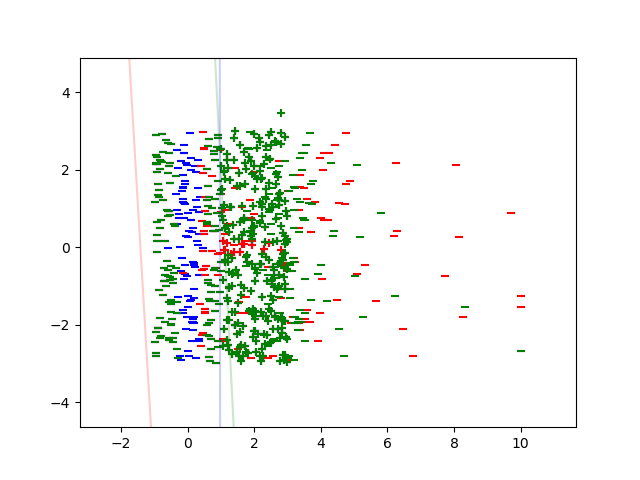

In [546]:
# data = {}
# data['X'] = X.numpy().tolist()
# data['Y'] = Y.numpy().tolist()
# data['w_fixed'] = w_fixed.numpy().tolist()
# data['w_fixed'] = b_fixed.numpy().tolist()
# data['w_flexible'] = w_flexible.numpy().tolist()
# data['b_flexible'] = b_flexible.numpy().tolist()
# data['v'] = v_flexible.numpy().tolist()
# data['info'] = "epochs:10, batch:32, COST:0.5"

# with open('fixed_VS_flexible_cost_dependOn.txt', 'w') as outfile:
#     json.dump(data, outfile)

print("non-strategic: y vs f(x):\n{}\naccuracy: {}".format(*conf_mat(Yval, FX)))
print("fixed: y vs f\'(x\'):\n{}\naccuracy: {}".format(*conf_mat(Yval, FpXp_fixed)))
print("flexible: y vs f\'(x\'):\n{}\naccuracy: {}".format(*conf_mat(Yval, FpXp_flexible)))

visualize_strategic_data(Xval, Xval_opt_fixed, Xval_opt_flexible, Yval, w_non_strategic, b_non_strategic, w_fixed, b_fixed, w_flexible, b_flexible)

# tradeoff

In [569]:
EPOCHS = 10
BATCH_SIZE = 32

with open("fixed_VS_flexible_tradeoff.txt", "a+") as file:
        file.write("format: lambda|v|accuracy\n")
        file.write("2D data. minus blob from -1 to 1, plus blob from 1 to 3. v_init = 1\n")
        
lambda_range = torch.logspace(start=-3, end=0.1, steps=20)
print(lambda_range)
for lam in lambda_range:
    
    # train
    print("---------- training strategically on lambda: {} ----------".format(lam))
    
    # strategic classification with flexible v
    w_flexible = torch.zeros(XDIM, requires_grad=True)
    b_flexible = torch.zeros(1, requires_grad=True)
    v_flexible = torch.ones(XDIM, requires_grad=True)

    fit_res_flexible = fit(lambda X, Y: evaluate_model(X, Y, w_flexible, b_flexible, v_flexible, ccp, strategic=True), 
                                   lambda X, Y: loss(X, Y, w_flexible, b_flexible, v_flexible, lam, strategic=True), [w_flexible, b_flexible, v_flexible], X, Y, Xval, Yval,
                                   opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                                   batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False)

    w_flexible.requires_grad = False
    b_flexible.requires_grad = False
    v_flexible.requires_grad = False
    v_flexible = torch.abs(v_flexible)
    print("v flexible: ", v_flexible)

    # evaluate results
    print("evaluating...")
    
    accuracy = evaluate_model(Xval, Yval, w_flexible, b_flexible, v_flexible, ccp, strategic=True)
    
    # log
    print("logging...")
    
    with open("fixed_VS_flexible_tradeoff.txt", "a+") as file:
        file.write("%3.5f|%3.9f|" % (lam, accuracy))
        file.write(str(v_flexible))
        file.write("\n")
        

tensor([1.0000e-03, 1.4560e-03, 2.1199e-03, 3.0866e-03, 4.4940e-03, 6.5432e-03,
        9.5268e-03, 1.3871e-02, 2.0196e-02, 2.9405e-02, 4.2813e-02, 6.2336e-02,
        9.0760e-02, 1.3215e-01, 1.9240e-01, 2.8014e-01, 4.0787e-01, 5.9386e-01,
        8.6465e-01, 1.2589e+00])
---------- training strategically on lambda: 0.001 ----------
batch 001 / 016 | loss: 1.00000
batch 002 / 016 | loss: 0.95498
batch 003 / 016 | loss: 0.96456
batch 004 / 016 | loss: 1.00539
batch 005 / 016 | loss: 0.93366
batch 006 / 016 | loss: 0.87959
batch 007 / 016 | loss: 0.94115
batch 008 / 016 | loss: 0.95033
batch 009 / 016 | loss: 0.92555
batch 010 / 016 | loss: 0.92291
batch 011 / 016 | loss: 0.93140
batch 012 / 016 | loss: 0.89987
batch 013 / 016 | loss: 0.91071
batch 014 / 016 | loss: 0.90080
batch 015 / 016 | loss: 0.89985
batch 016 / 016 | loss: 0.90195
batch 001 / 016 | loss: 0.53883
batch 002 / 016 | loss: 0.68615
batch 003 / 016 | loss: 0.72494
batch 004 / 016 | loss: 0.79691
batch 005 / 016 | loss: 0

batch 001 / 016 | loss: 0.32268
batch 002 / 016 | loss: 0.49007
batch 003 / 016 | loss: 0.37729
batch 004 / 016 | loss: 0.36876
batch 005 / 016 | loss: 0.44017
batch 006 / 016 | loss: 0.47884
batch 007 / 016 | loss: 0.51933
batch 008 / 016 | loss: 0.48972
batch 009 / 016 | loss: 0.48471
batch 010 / 016 | loss: 0.48977
batch 011 / 016 | loss: 0.49633
batch 012 / 016 | loss: 0.48265
batch 013 / 016 | loss: 0.47974
batch 014 / 016 | loss: 0.46985
batch 015 / 016 | loss: 0.47729
batch 016 / 016 | loss: 0.47632
batch 001 / 016 | loss: 0.60068
batch 002 / 016 | loss: 0.46943
batch 003 / 016 | loss: 0.49859
batch 004 / 016 | loss: 0.43640
batch 005 / 016 | loss: 0.42473
batch 006 / 016 | loss: 0.43827
batch 007 / 016 | loss: 0.46342
batch 008 / 016 | loss: 0.49007
batch 009 / 016 | loss: 0.45035
batch 010 / 016 | loss: 0.44482
batch 011 / 016 | loss: 0.42914
batch 012 / 016 | loss: 0.41567
batch 013 / 016 | loss: 0.41382
batch 014 / 016 | loss: 0.41149
batch 015 / 016 | loss: 0.42550
batch 01

batch 006 / 016 | loss: 0.95281
batch 007 / 016 | loss: 0.95622
batch 008 / 016 | loss: 0.95375
batch 009 / 016 | loss: 0.95878
batch 010 / 016 | loss: 0.95446
batch 011 / 016 | loss: 0.95975
batch 012 / 016 | loss: 0.95967
batch 013 / 016 | loss: 0.96378
batch 014 / 016 | loss: 0.96107
batch 015 / 016 | loss: 0.93490
batch 016 / 016 | loss: 0.93792
batch 001 / 016 | loss: 0.69444
batch 002 / 016 | loss: 0.80676
batch 003 / 016 | loss: 0.86160
batch 004 / 016 | loss: 0.82318
batch 005 / 016 | loss: 0.74437
batch 006 / 016 | loss: 0.78006
batch 007 / 016 | loss: 0.78893
batch 008 / 016 | loss: 0.76079
batch 009 / 016 | loss: 0.73776
batch 010 / 016 | loss: 0.72687
batch 011 / 016 | loss: 0.70694
batch 012 / 016 | loss: 0.69531
batch 013 / 016 | loss: 0.69221
batch 014 / 016 | loss: 0.70165
batch 015 / 016 | loss: 0.69263
batch 016 / 016 | loss: 0.72570
batch 001 / 016 | loss: 0.37530
batch 002 / 016 | loss: 0.52971
batch 003 / 016 | loss: 0.60132
batch 004 / 016 | loss: 0.65681
batch 00

batch 001 / 016 | loss: 0.45520
batch 002 / 016 | loss: 0.53272
batch 003 / 016 | loss: 0.44735
batch 004 / 016 | loss: 0.42207
batch 005 / 016 | loss: 0.47704
batch 006 / 016 | loss: 0.43802
batch 007 / 016 | loss: 0.40296
batch 008 / 016 | loss: 0.38596
batch 009 / 016 | loss: 0.39362
batch 010 / 016 | loss: 0.43278
batch 011 / 016 | loss: 0.43155
batch 012 / 016 | loss: 0.42254
batch 013 / 016 | loss: 0.41626
batch 014 / 016 | loss: 0.42623
batch 015 / 016 | loss: 0.42107
batch 016 / 016 | loss: 0.40791
batch 001 / 016 | loss: 0.10214
batch 002 / 016 | loss: 0.25787
batch 003 / 016 | loss: 0.30229
batch 004 / 016 | loss: 0.35452
batch 005 / 016 | loss: 0.34293
batch 006 / 016 | loss: 0.36157
batch 007 / 016 | loss: 0.35629
batch 008 / 016 | loss: 0.36481
batch 009 / 016 | loss: 0.39782
batch 010 / 016 | loss: 0.41684
batch 011 / 016 | loss: 0.40313
batch 012 / 016 | loss: 0.37839
batch 013 / 016 | loss: 0.37127
batch 014 / 016 | loss: 0.36424
batch 015 / 016 | loss: 0.35323
batch 01

batch 006 / 016 | loss: 0.87229
batch 007 / 016 | loss: 0.81479
batch 008 / 016 | loss: 0.80606
batch 009 / 016 | loss: 0.78389
batch 010 / 016 | loss: 0.77350
batch 011 / 016 | loss: 0.77255
batch 012 / 016 | loss: 0.75778
batch 013 / 016 | loss: 0.75916
batch 014 / 016 | loss: 0.73513
batch 015 / 016 | loss: 0.71516
batch 016 / 016 | loss: 0.72347
batch 001 / 016 | loss: 0.60191
batch 002 / 016 | loss: 0.62247
batch 003 / 016 | loss: 0.65110
batch 004 / 016 | loss: 0.70905
batch 005 / 016 | loss: 0.70698
batch 006 / 016 | loss: 0.70147
batch 007 / 016 | loss: 0.67674
batch 008 / 016 | loss: 0.65086
batch 009 / 016 | loss: 0.64538
batch 010 / 016 | loss: 0.67799
batch 011 / 016 | loss: 0.68233
batch 012 / 016 | loss: 0.67881
batch 013 / 016 | loss: 0.70471
batch 014 / 016 | loss: 0.70136
batch 015 / 016 | loss: 0.70115
batch 016 / 016 | loss: 0.68634
batch 001 / 016 | loss: 0.66572
batch 002 / 016 | loss: 0.51868
batch 003 / 016 | loss: 0.44493
batch 004 / 016 | loss: 0.46168
batch 00

batch 001 / 016 | loss: 0.48693
batch 002 / 016 | loss: 0.50899
batch 003 / 016 | loss: 0.60992
batch 004 / 016 | loss: 0.61369
batch 005 / 016 | loss: 0.64490
batch 006 / 016 | loss: 0.61595
batch 007 / 016 | loss: 0.59924
batch 008 / 016 | loss: 0.60220
batch 009 / 016 | loss: 0.58722
batch 010 / 016 | loss: 0.57544
batch 011 / 016 | loss: 0.58312
batch 012 / 016 | loss: 0.56073
batch 013 / 016 | loss: 0.55575
batch 014 / 016 | loss: 0.54344
batch 015 / 016 | loss: 0.54483
batch 016 / 016 | loss: 0.54188
batch 001 / 016 | loss: 0.40504
batch 002 / 016 | loss: 0.47665
batch 003 / 016 | loss: 0.52955
batch 004 / 016 | loss: 0.49810
batch 005 / 016 | loss: 0.48715
batch 006 / 016 | loss: 0.49374
batch 007 / 016 | loss: 0.55325
batch 008 / 016 | loss: 0.57260
batch 009 / 016 | loss: 0.58576
batch 010 / 016 | loss: 0.58064
batch 011 / 016 | loss: 0.57589
batch 012 / 016 | loss: 0.56875
batch 013 / 016 | loss: 0.54983
batch 014 / 016 | loss: 0.57109
batch 015 / 016 | loss: 0.57342
batch 01

batch 006 / 016 | loss: 0.67899
batch 007 / 016 | loss: 0.67040
batch 008 / 016 | loss: 0.69946
batch 009 / 016 | loss: 0.73012
batch 010 / 016 | loss: 0.71313
batch 011 / 016 | loss: 0.69396
batch 012 / 016 | loss: 0.69862
batch 013 / 016 | loss: 0.69808
batch 014 / 016 | loss: 0.68595
batch 015 / 016 | loss: 0.71276
batch 016 / 016 | loss: 0.71443
batch 001 / 016 | loss: 1.06360
batch 002 / 016 | loss: 0.88730
batch 003 / 016 | loss: 0.89719
batch 004 / 016 | loss: 0.82464
batch 005 / 016 | loss: 0.79241
batch 006 / 016 | loss: 0.75037
batch 007 / 016 | loss: 0.73354
batch 008 / 016 | loss: 0.71291
batch 009 / 016 | loss: 0.71301
batch 010 / 016 | loss: 0.71367
batch 011 / 016 | loss: 0.71951
batch 012 / 016 | loss: 0.70368
batch 013 / 016 | loss: 0.69203
batch 014 / 016 | loss: 0.68768
batch 015 / 016 | loss: 0.68677
batch 016 / 016 | loss: 0.68438
batch 001 / 016 | loss: 0.62234
batch 002 / 016 | loss: 0.64015
batch 003 / 016 | loss: 0.62367
batch 004 / 016 | loss: 0.70674
batch 00

batch 001 / 016 | loss: 0.56041
batch 002 / 016 | loss: 0.56372
batch 003 / 016 | loss: 0.56782
batch 004 / 016 | loss: 0.53487
batch 005 / 016 | loss: 0.61464
batch 006 / 016 | loss: 0.72142
batch 007 / 016 | loss: 0.73252
batch 008 / 016 | loss: 0.71796
batch 009 / 016 | loss: 0.75153
batch 010 / 016 | loss: 0.76450
batch 011 / 016 | loss: 0.76083
batch 012 / 016 | loss: 0.78925
batch 013 / 016 | loss: 0.77781
batch 014 / 016 | loss: 0.77510
batch 015 / 016 | loss: 0.76645
batch 016 / 016 | loss: 0.73954
batch 001 / 016 | loss: 0.64868
batch 002 / 016 | loss: 0.63927
batch 003 / 016 | loss: 0.68942
batch 004 / 016 | loss: 0.67015
batch 005 / 016 | loss: 0.70010
batch 006 / 016 | loss: 0.74430
batch 007 / 016 | loss: 0.73888
batch 008 / 016 | loss: 0.70215
batch 009 / 016 | loss: 0.66090
batch 010 / 016 | loss: 0.66458
batch 011 / 016 | loss: 0.68657
batch 012 / 016 | loss: 0.69939
batch 013 / 016 | loss: 0.68076
batch 014 / 016 | loss: 0.70162
batch 015 / 016 | loss: 0.71116
batch 01

batch 006 / 016 | loss: 0.77616
batch 007 / 016 | loss: 0.74048
batch 008 / 016 | loss: 0.77392
batch 009 / 016 | loss: 0.79848
batch 010 / 016 | loss: 0.78831
batch 011 / 016 | loss: 0.79919
batch 012 / 016 | loss: 0.83592
batch 013 / 016 | loss: 0.86714
batch 014 / 016 | loss: 0.86576
batch 015 / 016 | loss: 0.84835
batch 016 / 016 | loss: 0.84205
batch 001 / 016 | loss: 0.76800
batch 002 / 016 | loss: 0.82087
batch 003 / 016 | loss: 0.80812
batch 004 / 016 | loss: 0.82673
batch 005 / 016 | loss: 0.81191
batch 006 / 016 | loss: 0.82864
batch 007 / 016 | loss: 0.84323
batch 008 / 016 | loss: 0.92560
batch 009 / 016 | loss: 0.90674
batch 010 / 016 | loss: 0.87343
batch 011 / 016 | loss: 0.85980
batch 012 / 016 | loss: 0.85965
batch 013 / 016 | loss: 0.86441
batch 014 / 016 | loss: 0.86579
batch 015 / 016 | loss: 0.86079
batch 016 / 016 | loss: 0.86711
batch 001 / 016 | loss: 0.88472
batch 002 / 016 | loss: 0.79752
batch 003 / 016 | loss: 0.73154
batch 004 / 016 | loss: 0.85697
batch 00

batch 001 / 016 | loss: 0.85866
batch 002 / 016 | loss: 0.84349
batch 003 / 016 | loss: 0.82826
batch 004 / 016 | loss: 0.87308
batch 005 / 016 | loss: 0.85975
batch 006 / 016 | loss: 0.83483
batch 007 / 016 | loss: 0.83308
batch 008 / 016 | loss: 0.83173
batch 009 / 016 | loss: 0.83845
batch 010 / 016 | loss: 0.82443
batch 011 / 016 | loss: 0.80903
batch 012 / 016 | loss: 0.83628
batch 013 / 016 | loss: 0.82199
batch 014 / 016 | loss: 0.82959
batch 015 / 016 | loss: 0.83334
batch 016 / 016 | loss: 0.82293
training time: 248.38538336753845 seconds
v flexible:  tensor([2.0361, 0.5715])
evaluating...
logging...
---------- training strategically on lambda: 0.19240241827602386 ----------
batch 001 / 016 | loss: 1.00000
batch 002 / 016 | loss: 0.95512
batch 003 / 016 | loss: 0.89056
batch 004 / 016 | loss: 0.92720
batch 005 / 016 | loss: 0.94932
batch 006 / 016 | loss: 1.03414
batch 007 / 016 | loss: 1.06258
batch 008 / 016 | loss: 1.05245
batch 009 / 016 | loss: 1.03871
batch 010 / 016 | l

batch 006 / 016 | loss: 0.92237
batch 007 / 016 | loss: 0.91576
batch 008 / 016 | loss: 0.88775
batch 009 / 016 | loss: 0.85108
batch 010 / 016 | loss: 0.85377
batch 011 / 016 | loss: 0.86187
batch 012 / 016 | loss: 0.87036
batch 013 / 016 | loss: 0.88451
batch 014 / 016 | loss: 0.86237
batch 015 / 016 | loss: 0.85078
batch 016 / 016 | loss: 0.83537
batch 001 / 016 | loss: 0.67543
batch 002 / 016 | loss: 0.76037
batch 003 / 016 | loss: 0.86743
batch 004 / 016 | loss: 0.80467
batch 005 / 016 | loss: 0.84563
batch 006 / 016 | loss: 0.84498
batch 007 / 016 | loss: 0.85731
batch 008 / 016 | loss: 0.87132
batch 009 / 016 | loss: 0.83058
batch 010 / 016 | loss: 0.83934
batch 011 / 016 | loss: 0.81659
batch 012 / 016 | loss: 0.81829
batch 013 / 016 | loss: 0.80668
batch 014 / 016 | loss: 0.81491
batch 015 / 016 | loss: 0.80661
batch 016 / 016 | loss: 0.82645
batch 001 / 016 | loss: 0.50586
batch 002 / 016 | loss: 0.60698
batch 003 / 016 | loss: 0.72433
batch 004 / 016 | loss: 0.79316
batch 00

logging...
---------- training strategically on lambda: 0.5938601867590266 ----------
batch 001 / 016 | loss: 1.00000
batch 002 / 016 | loss: 0.99004
batch 003 / 016 | loss: 1.05703
batch 004 / 016 | loss: 1.04601
batch 005 / 016 | loss: 1.05828
batch 006 / 016 | loss: 1.04554
batch 007 / 016 | loss: 1.03678
batch 008 / 016 | loss: 1.03169
batch 009 / 016 | loss: 1.03037
batch 010 / 016 | loss: 1.01609
batch 011 / 016 | loss: 1.00460
batch 012 / 016 | loss: 0.99229
batch 013 / 016 | loss: 0.97783
batch 014 / 016 | loss: 0.98423
batch 015 / 016 | loss: 0.98334
batch 016 / 016 | loss: 0.97819
batch 001 / 016 | loss: 0.92020
batch 002 / 016 | loss: 0.93951
batch 003 / 016 | loss: 0.89119
batch 004 / 016 | loss: 0.96452
batch 005 / 016 | loss: 0.91864
batch 006 / 016 | loss: 0.91442
batch 007 / 016 | loss: 0.94420
batch 008 / 016 | loss: 0.94787
batch 009 / 016 | loss: 0.96740
batch 010 / 016 | loss: 0.99249
batch 011 / 016 | loss: 1.02063
batch 012 / 016 | loss: 1.02519
batch 013 / 016 | 

batch 009 / 016 | loss: 0.93323
batch 010 / 016 | loss: 0.91917
batch 011 / 016 | loss: 0.90875
batch 012 / 016 | loss: 0.89650
batch 013 / 016 | loss: 0.90155
batch 014 / 016 | loss: 0.88707
batch 015 / 016 | loss: 0.89558
batch 016 / 016 | loss: 0.89328
batch 001 / 016 | loss: 0.96648
batch 002 / 016 | loss: 0.86637
batch 003 / 016 | loss: 0.87940
batch 004 / 016 | loss: 0.81836
batch 005 / 016 | loss: 0.86207
batch 006 / 016 | loss: 0.88379
batch 007 / 016 | loss: 0.88727
batch 008 / 016 | loss: 0.91494
batch 009 / 016 | loss: 0.95201
batch 010 / 016 | loss: 0.92911
batch 011 / 016 | loss: 0.95129
batch 012 / 016 | loss: 0.90964
batch 013 / 016 | loss: 0.89418
batch 014 / 016 | loss: 0.91551
batch 015 / 016 | loss: 0.90679
batch 016 / 016 | loss: 0.90783
batch 001 / 016 | loss: 1.24127
batch 002 / 016 | loss: 1.12037
batch 003 / 016 | loss: 1.13263
batch 004 / 016 | loss: 1.00448
batch 005 / 016 | loss: 0.95543
batch 006 / 016 | loss: 0.98434
batch 007 / 016 | loss: 0.92849
batch 00

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


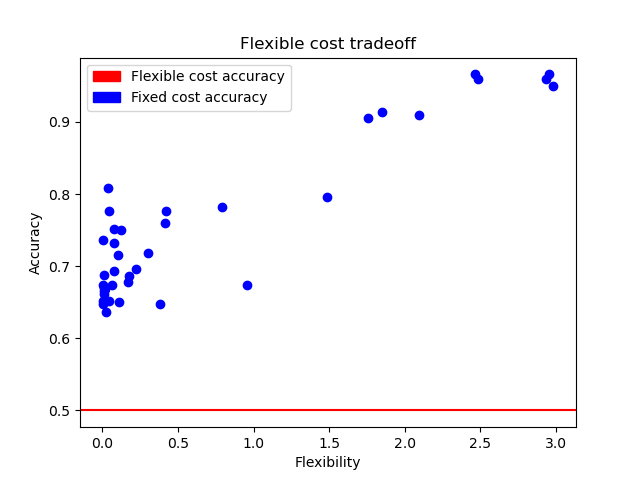

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [583]:
accuracies = []
v_sum_diffs = []

with open("fixed_VS_flexible_tradeoff.txt", "r+") as file:
    Lines = file.readlines()[2:] 
    
    for line in Lines:
        info = line.split("|")
        
        accuracy = float(info[1])
        accuracies.append(accuracy)
        v = info[2][:-1].strip('][').split(', ')
        v = list(map(float, v))
        v_sum_diffs.append(abs(sum(v) - XDIM)/XDIM)
        

v_sum_diffs.reverse()
accuracies.reverse()

fig = plt.figure()
plt.title('Flexible cost tradeoff')
plt.xlabel('Flexibility')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
ax.scatter(v_sum_diffs, accuracies, color='b')
plt.axhline(y=0.5, linestyle='-', color='r')

red_patch = mpatches.Patch(color='r', label='Flexible cost accuracy')
blue_patch = mpatches.Patch(color='b', label='Fixed cost accuracy')

plt.legend(handles=[red_patch, blue_patch])
# plt.savefig('plots/flexible_cost_tradeoff.pdf', format='pdf')
# plt.savefig('plots/flexible_cost_tradeoff.eps', format='eps')
# plt.savefig('plots/flexible_cost_tradeoff.png', format='png')
plt.show()